In [1]:
from data_manipulation.loaders import *
from glob import glob
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras import metrics
from tensorflow.keras.losses import mse
import segmentation_models as sm
import numpy as np
import os
from tensorflow.keras.models import load_model
from PIL import ImageOps
import PIL
from IPython.display import Image, display
import imageio

from config import config as cfg
from custom_objects.custom_loss import custom_loss
import matplotlib.pyplot as plt

Segmentation Models: using `tf.keras` framework.


In [2]:
data = Dataset(cfg['dataset_path'], cfg['images_path'], cfg['modality'],
                initial_slice=cfg['initial_slice'], final_slice=cfg['final_slice'], extract=False)

>> Filtering black images (without ground truth)..
<< Done!

>> Searching for sets in csv format..
!! Found them.


In [3]:
def visualize_prediction(i, val_preds):
    img = data.test[i][0]
    img_arr = cv2.imread(img)
    plt.imshow(img_arr)
    plt.show()
    gt = data.test[i][1]
    gt_arr = cv2.imread(gt, 0)
    plt.imshow(gt_arr) 
    plt.show()
    plt.imshow(np.argmax(val_preds[i], axis=-1))
    
    plt.show()

In [4]:
model = 3

In [5]:
class CustomMeanIOU(tf.keras.metrics.MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        return super().update_state(tf.argmax(y_true, axis=-1), tf.argmax(y_pred, axis=-1), sample_weight)

In [6]:
def save_preds(val_preds, out):
    for i in range(len(val_preds)):
        mask = np.argmax(val_preds[i], axis=-1)
        mask = np.expand_dims(mask, axis=-1)
        imageio.imwrite(out + 'predict_{:04d}'.format(i) + '.png', mask.astype(np.uint8))

In [7]:
if model == 2:
    modelo_salvo = load_model('modelo2.h5', custom_objects={'dice_loss': sm.losses.jaccard_loss, 'f1-score': sm.metrics.f1_score, 'CustomMeanIOU': CustomMeanIOU})
elif model == 3:
    modelo_salvo = load_model('modelo3.h5', custom_objects={'jaccard_loss': sm.losses.jaccard_loss, 'f1-score': sm.metrics.f1_score, 'CustomMeanIOU': CustomMeanIOU})

In [8]:
test_generator = DataGenerator(data.test, batch_size=16)
val_preds = modelo_salvo.predict(test_generator, verbose=1)

77/77 [==============================] - 6s 38ms/step


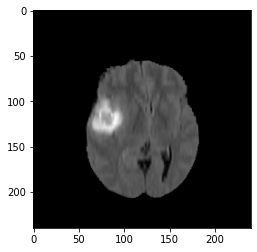

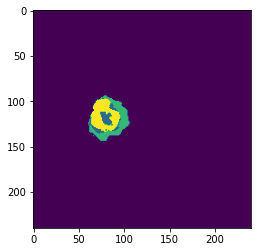

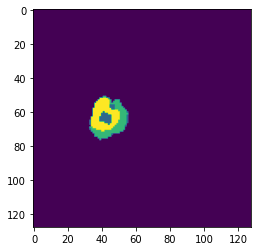

In [9]:
visualize_prediction(11, val_preds)

In [10]:
out = f'predictions/model{model}/'
os.makedirs(out)
save_preds(val_preds, out)